# light gbm 데모
* boosting_여러 결정트리를 이전 트리의 오차를 줄이는 방향으로 순차적 학습
* gbm_개별 결정트리의 bias(에러를 점차적으로 감소)를 효과적으로 감소시켜 성능 향상

## 라이브러리 import 및 설정

In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [20]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [21]:
data_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')
sub_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\sub\\')
feature_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
seed = 42

In [22]:
algo_name = 'lgb'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [23]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [24]:
y = df[target_col].values[:320000]         #종속
df.drop(target_col, axis=1, inplace=True)  #독립을 위한 종속 제거
trn = df.iloc[:320000]                     #train을 위한 독립 320000개     
tst = df.iloc[320000:]                     #test을 위한 독립 80000개
feature_name = df.columns.tolist()         #독립변수 이름 리스트로 변환
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## 학습/검증 데이터 구분
**학습 후 모델의 예측/분류 정확도 계산을 위한 검증데이터 분리**

[Hold-out Validation]

In [25]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(256000, 19) (64000, 19) (256000,) (64000,)


## LightGBM 모델 학습

In [26]:
clf = lgb.LGBMClassifier(objective='multiclass',
                         n_estimators=1000,
                         #사용하는 개별 결정트리
                         num_leaves=200,
                         #2의 자승으로 줄 것
                         learning_rate=0.01,
                         #작을 수록 스케일이 줄어든다. 원하는 예측값까지 
                         #수렴하기 위해 큰 변동(Oscillation)없이 안정적으로 도달 가능 
                         #대신 필요한 개별 결정트리 증가로 학습시간이 급증할 수 있다.
                         min_child_samples=10,
                         subsample=.5,
                         #각 트리의 몇퍼센트 데이터를 쓸것인가
                         subsample_freq=1,
                         #각 트리 샘플링 빈도
                         colsample_bytree=.8,
                         #피처 샘플링 빈도(80% 사용)
                         random_state=seed,
                         n_jobs=-1)

clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='multiclass',early_stopping_rounds=10)                         
                                     #학습 데이터로 훈련(learning)
                                     #+ eval_set: 검증 데이터 패스,  
                                     #+ eval_metric: 매번 실행하는 횟수마다 로그손실 확인 가능
                                     #+ eval_metric: 손실함수 향상의 계산 한계를 지정
p_val = clf.predict(X_val)           #학습데이터로 훈련시킨 모델에 검증데이터로 예측값 추출
p_tst = clf.predict(tst)             #학습데이터로 훈련시킨 모델에 테스트데이터로 예측값 추출

[1]	valid_0's multi_logloss: 0.972541
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.959116
[3]	valid_0's multi_logloss: 0.945298
[4]	valid_0's multi_logloss: 0.931676
[5]	valid_0's multi_logloss: 0.918549
[6]	valid_0's multi_logloss: 0.907054
[7]	valid_0's multi_logloss: 0.895356
[8]	valid_0's multi_logloss: 0.8849
[9]	valid_0's multi_logloss: 0.87372
[10]	valid_0's multi_logloss: 0.861837
[11]	valid_0's multi_logloss: 0.850471
[12]	valid_0's multi_logloss: 0.839379
[13]	valid_0's multi_logloss: 0.828506
[14]	valid_0's multi_logloss: 0.817671
[15]	valid_0's multi_logloss: 0.80713
[16]	valid_0's multi_logloss: 0.797154
[17]	valid_0's multi_logloss: 0.7873
[18]	valid_0's multi_logloss: 0.777506
[19]	valid_0's multi_logloss: 0.767807
[20]	valid_0's multi_logloss: 0.758987
[21]	valid_0's multi_logloss: 0.749679
[22]	valid_0's multi_logloss: 0.740634
[23]	valid_0's multi_logloss: 0.731642
[24]	valid_0's multi_logloss: 0.723654
[25]	valid_0's mul

[208]	valid_0's multi_logloss: 0.225322
[209]	valid_0's multi_logloss: 0.224745
[210]	valid_0's multi_logloss: 0.224238
[211]	valid_0's multi_logloss: 0.223575
[212]	valid_0's multi_logloss: 0.222988
[213]	valid_0's multi_logloss: 0.222344
[214]	valid_0's multi_logloss: 0.221731
[215]	valid_0's multi_logloss: 0.221106
[216]	valid_0's multi_logloss: 0.220466
[217]	valid_0's multi_logloss: 0.21992
[218]	valid_0's multi_logloss: 0.219335
[219]	valid_0's multi_logloss: 0.218806
[220]	valid_0's multi_logloss: 0.218211
[221]	valid_0's multi_logloss: 0.217693
[222]	valid_0's multi_logloss: 0.217234
[223]	valid_0's multi_logloss: 0.216694
[224]	valid_0's multi_logloss: 0.216235
[225]	valid_0's multi_logloss: 0.215709
[226]	valid_0's multi_logloss: 0.215213
[227]	valid_0's multi_logloss: 0.214732
[228]	valid_0's multi_logloss: 0.214177
[229]	valid_0's multi_logloss: 0.213728
[230]	valid_0's multi_logloss: 0.213201
[231]	valid_0's multi_logloss: 0.21271
[232]	valid_0's multi_logloss: 0.212213
[2

[414]	valid_0's multi_logloss: 0.171812
[415]	valid_0's multi_logloss: 0.171728
[416]	valid_0's multi_logloss: 0.171655
[417]	valid_0's multi_logloss: 0.171571
[418]	valid_0's multi_logloss: 0.171499
[419]	valid_0's multi_logloss: 0.171417
[420]	valid_0's multi_logloss: 0.171338
[421]	valid_0's multi_logloss: 0.17125
[422]	valid_0's multi_logloss: 0.171169
[423]	valid_0's multi_logloss: 0.171083
[424]	valid_0's multi_logloss: 0.171003
[425]	valid_0's multi_logloss: 0.170946
[426]	valid_0's multi_logloss: 0.170871
[427]	valid_0's multi_logloss: 0.170793
[428]	valid_0's multi_logloss: 0.170709
[429]	valid_0's multi_logloss: 0.170649
[430]	valid_0's multi_logloss: 0.17057
[431]	valid_0's multi_logloss: 0.170481
[432]	valid_0's multi_logloss: 0.170409
[433]	valid_0's multi_logloss: 0.17033
[434]	valid_0's multi_logloss: 0.170264
[435]	valid_0's multi_logloss: 0.170204
[436]	valid_0's multi_logloss: 0.170153
[437]	valid_0's multi_logloss: 0.170096
[438]	valid_0's multi_logloss: 0.170023
[43

[620]	valid_0's multi_logloss: 0.163282
[621]	valid_0's multi_logloss: 0.163266
[622]	valid_0's multi_logloss: 0.163247
[623]	valid_0's multi_logloss: 0.163236
[624]	valid_0's multi_logloss: 0.163209
[625]	valid_0's multi_logloss: 0.163189
[626]	valid_0's multi_logloss: 0.163163
[627]	valid_0's multi_logloss: 0.16315
[628]	valid_0's multi_logloss: 0.163142
[629]	valid_0's multi_logloss: 0.16313
[630]	valid_0's multi_logloss: 0.163116
[631]	valid_0's multi_logloss: 0.163103
[632]	valid_0's multi_logloss: 0.163086
[633]	valid_0's multi_logloss: 0.163069
[634]	valid_0's multi_logloss: 0.163054
[635]	valid_0's multi_logloss: 0.163033
[636]	valid_0's multi_logloss: 0.163015
[637]	valid_0's multi_logloss: 0.163008
[638]	valid_0's multi_logloss: 0.162989
[639]	valid_0's multi_logloss: 0.162971
[640]	valid_0's multi_logloss: 0.162952
[641]	valid_0's multi_logloss: 0.162935
[642]	valid_0's multi_logloss: 0.162925
[643]	valid_0's multi_logloss: 0.162907
[644]	valid_0's multi_logloss: 0.162894
[6

[826]	valid_0's multi_logloss: 0.16131
[827]	valid_0's multi_logloss: 0.161307
[828]	valid_0's multi_logloss: 0.161297
[829]	valid_0's multi_logloss: 0.161304
[830]	valid_0's multi_logloss: 0.161301
[831]	valid_0's multi_logloss: 0.161298
[832]	valid_0's multi_logloss: 0.161299
[833]	valid_0's multi_logloss: 0.161299
[834]	valid_0's multi_logloss: 0.161287
[835]	valid_0's multi_logloss: 0.161288
[836]	valid_0's multi_logloss: 0.161286
[837]	valid_0's multi_logloss: 0.161279
[838]	valid_0's multi_logloss: 0.161277
[839]	valid_0's multi_logloss: 0.161276
[840]	valid_0's multi_logloss: 0.161275
[841]	valid_0's multi_logloss: 0.161275
[842]	valid_0's multi_logloss: 0.161272
[843]	valid_0's multi_logloss: 0.161262
[844]	valid_0's multi_logloss: 0.161268
[845]	valid_0's multi_logloss: 0.161257
[846]	valid_0's multi_logloss: 0.161252
[847]	valid_0's multi_logloss: 0.16125
[848]	valid_0's multi_logloss: 0.16125
[849]	valid_0's multi_logloss: 0.161246
[850]	valid_0's multi_logloss: 0.161242
[85

In [27]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')

93.2609%


## 피처 중요도 시각화
* 여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

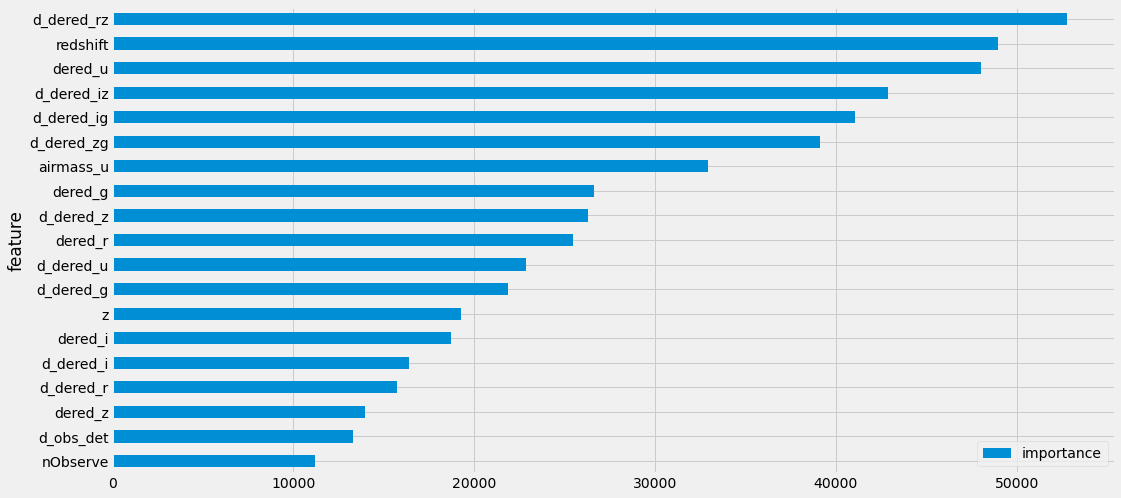

In [28]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [29]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [30]:
sub[target_col] = p_tst
sub.head()

,class
id,
320000,2.0
320001,0.0
320002,2.0
320003,0.0
320004,2.0


In [31]:
sub[target_col].value_counts()


2.0    40998
0.0    29975
1.0     9027
Name: class, dtype: int64

## 파일 저장

In [38]:
sub.to_csv(sub_file)